# Experiment: Fidelity of Iterative Projection vs. Initial State Complexity

## Overview
This notebook investigates how the fidelity between an initial quantum state and the state resulting from an iterative projection process changes with the complexity (ansatz depth) of the initial state.

The process for each run is:
1. Generate an initial N-qubit quantum state, `|psi_initial>`, using a `RealAmplitudes` ansatz with a specific `PSI_ANSATZ_DEPTH`.
2. Optimize rank-1 projectors `P_ij*` for each nearest-neighbor pair to minimize `<psi_initial|P_ij*|psi_initial>`.
3. Sequentially apply filter operators `(I - P_ij*)` to `|psi_initial>` and renormalize, producing `|psi_final>`.
4. Calculate the fidelity $F(|\psi_{initial}\rangle, |\psi_{final}\rangle)$.

This is repeated for several random instances at each `PSI_ANSATZ_DEPTH` (from 0 to 8). The average fidelity for each depth is then plotted against the `PSI_ANSATZ_DEPTH`.

## Requirements
- `numpy`
- `qiskit`
- `scipy`
- `matplotlib` (for plotting)

## 1. Imports and Setup

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, state_fidelity
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt # For plotting
import time # To time the experiment

try:
    from scipy.optimize import minimize
except ModuleNotFoundError:
    print("ERROR: scipy is not installed. Please install it: pip install scipy")
    def minimize(*args, **kwargs):
        raise RuntimeError("scipy.optimize.minimize not found. Please install scipy.")

## 2. Experiment Configuration

In [6]:
# --- Experiment Configuration ---
NUM_QUBITS_EXP = 8           # Number of qubits for the experiment
MAX_PSI_ANSATZ_DEPTH = 8   # Max depth for RealAmplitudes (0 to MAX_PSI_ANSATZ_DEPTH)
NUM_RUNS_PER_DEPTH = 5     # Number of random instances per depth for averaging

# --- Fixed Parameters from previous setup (can be tuned) ---
PROJECTOR_U_REPS = 1       # Repetitions in TwoLocal for U(theta)
SCIPY_COBYLA_MAXITER = 10  # Max iterations for COBYLA (reduced for speed)
SCIPY_COBYLA_TOL = 1e-5      # Tolerance for COBYLA (adjusted)
MAIN_SEED = 42               # Main seed for reproducibility of the entire experiment

# Set NumPy's random seed. This will be reset for each run for comparable randomness.
np.random.seed(MAIN_SEED)
print(f"Main NumPy random seed for experiment: {MAIN_SEED}")

VISUALIZE_CIRCUITS = False # Set to True to draw circuits (can be verbose)
VERBOSE_OPTIMIZATION = False # Set to True for detailed optimizer output

Main NumPy random seed for experiment: 42


## 3. Core Logic Function
Encapsulate the process of generating a state, optimizing projectors, applying filters, and calculating fidelity into a function. This makes the main loop cleaner.

In [7]:
def run_single_projection_experiment(num_qubits, psi_depth, run_seed):
    """Runs one instance of the state generation, projector optimization, 
    and iterative filtering, returning the final fidelity."""
    np.random.seed(run_seed) # Set seed for this specific run

    # --- Step 1: Create initial quantum state |psi_initial> ---
    psi_ansatz = RealAmplitudes(num_qubits, reps=psi_depth, entanglement='linear')
    num_psi_params = psi_ansatz.num_parameters
    random_psi_params = np.random.rand(num_psi_params) * 2 * np.pi
    psi_circuit = psi_ansatz.assign_parameters(random_psi_params)

    if VISUALIZE_CIRCUITS and psi_depth > 0: # Avoid drawing empty circuit for depth 0
        print(f"  Run {run_seed}, Depth {psi_depth}: Initial state circuit:")
        try:
            display(psi_circuit.decompose().draw(output='mpl', style={'name': 'iqp'}, fold=-1))
        except Exception:
            display(psi_circuit.decompose().draw(output='text', fold=30))

    try:
        psi_initial_vector = Statevector(psi_circuit)
    except Exception as e:
        print(f"    ERROR (Run {run_seed}, Depth {psi_depth}): Could not create Statevector: {e}")
        return np.nan # Return NaN on failure

    # --- Step 2: Define base projectors and U(theta) ansatz ---
    proj_00_on_qubits_static_pauli_sum = {}
    for q1_idx in range(num_qubits - 1):
        q2_idx = q1_idx + 1
        pauli_list = [
            ("I" * num_qubits, 0.25),
            ("".join(['Z' if i == q1_idx else 'I' for i in range(num_qubits)]), 0.25),
            ("".join(['Z' if i == q2_idx else 'I' for i in range(num_qubits)]), 0.25),
            ("".join(['Z' if i == q1_idx or i == q2_idx else 'I' for i in range(num_qubits)]), 0.25)
        ]
        reversed_pauli_list = [(p_str[::-1], coeff) for p_str, coeff in pauli_list]
        proj_00_on_qubits_static_pauli_sum[(q1_idx, q2_idx)] = SparsePauliOp.from_list(reversed_pauli_list)

    u_ansatz_2q = TwoLocal(2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx',
                           reps=PROJECTOR_U_REPS, entanglement='linear')
    num_u_params = u_ansatz_2q.num_parameters

    # --- Step 3: Optimize projectors ---
    qubit_pairs = [(i, i + 1) for i in range(num_qubits - 1)]
    optimized_projectors_P_star = []

    for q1, q2 in qubit_pairs:
        base_proj_spo = proj_00_on_qubits_static_pauli_sum[(q1, q2)]
        def cost_func(params):
            try:
                u_circ_2q = u_ansatz_2q.assign_parameters(params)
                u_full_qc_ = QuantumCircuit(num_qubits)
                u_full_qc_.compose(u_circ_2q, qubits=[q1, q2], inplace=True)
                u_op = Operator(u_full_qc_)
                p_op_obj = u_op @ base_proj_spo @ u_op.adjoint()
                return np.real(psi_initial_vector.expectation_value(p_op_obj))
            except Exception:
                return np.nan 
        
        init_params = np.random.rand(num_u_params) * 2 * np.pi
        try:
            opt_res = minimize(fun=cost_func, x0=init_params, method='COBYLA',
                               tol=SCIPY_COBYLA_TOL, 
                               options={'maxiter': SCIPY_COBYLA_MAXITER, 'disp': VERBOSE_OPTIMIZATION})
            if opt_res.success or not np.isnan(opt_res.fun):
                u_circ_2q_opt_ = u_ansatz_2q.assign_parameters(opt_res.x)
                u_full_qc_opt_ = QuantumCircuit(num_qubits)
                u_full_qc_opt_.compose(u_circ_2q_opt_, qubits=[q1, q2], inplace=True)
                u_op_opt_ = Operator(u_full_qc_opt_)
                p_star_obj = u_op_opt_ @ base_proj_spo @ u_op_opt_.adjoint()
                optimized_projectors_P_star.append({'qubits': (q1,q2), 'P_star_op': p_star_obj})
            # else: print(f"    Opt failed for P_{q1}{q2} in run {run_seed}, depth {psi_depth}") # Optional
        except Exception:
            # print(f"    Exception in opt for P_{q1}{q2} in run {run_seed}, depth {psi_depth}") # Optional
            pass # Continue if one optimizer fails

    # --- Step 4: Iterative projection ---
    if not optimized_projectors_P_star:
        return state_fidelity(psi_initial_vector, psi_initial_vector) # Fidelity is 1 if no projectors
    
    current_psi = psi_initial_vector.copy()
    id_op = Operator(np.eye(2**num_qubits, dtype=complex))

    for p_info in optimized_projectors_P_star:
        k_op = id_op - p_info['P_star_op']
        proj_psi_unnorm = current_psi.evolve(k_op)
        norm = np.linalg.norm(proj_psi_unnorm.data)
        if norm < 1e-9:
            current_psi = Statevector(proj_psi_unnorm.data, dims=proj_psi_unnorm.dims())
            break
        current_psi = Statevector(proj_psi_unnorm.data / norm, dims=proj_psi_unnorm.dims())
    
    final_psi = current_psi

    # --- Step 5: Calculate Fidelity ---
    final_norm = np.linalg.norm(final_psi.data)
    if final_norm < 1e-9:
        return 0.0 # Fidelity with zero vector is zero
    if abs(final_norm - 1.0) > 1e-7:
        final_psi = Statevector(final_psi.data / final_norm, dims=final_psi.dims())
        
    # Ensure initial vector is normalized for fidelity calculation
    init_norm = np.linalg.norm(psi_initial_vector.data)
    if abs(init_norm - 1.0) > 1e-9:
        psi_initial_vector = Statevector(psi_initial_vector.data / init_norm, dims=psi_initial_vector.dims())
        
    return state_fidelity(psi_initial_vector, final_psi)



## 4. Running the Experiment
Iterate through different `PSI_ANSATZ_DEPTH` values. For each depth, run the projection experiment multiple times with different seeds (derived from `MAIN_SEED`) and store the average fidelity.

In [8]:
depth_values = list(range(MAX_PSI_ANSATZ_DEPTH + 1))
average_fidelities = []
std_fidelities = [] # To store standard deviation of fidelities

experiment_start_time = time.time()

for depth in depth_values:
    print(f"Processing PSI_ANSATZ_DEPTH = {depth}...")
    current_depth_fidelities = []
    depth_start_time = time.time()
    for i_run in range(NUM_RUNS_PER_DEPTH):
        # Create a unique seed for each run to ensure different initial states
        # and optimizer starting points, yet keeping the overall experiment reproducible.
        run_specific_seed = MAIN_SEED + depth * NUM_RUNS_PER_DEPTH + i_run
        print(f"  Run {i_run + 1}/{NUM_RUNS_PER_DEPTH} (Seed: {run_specific_seed})...")
        
        fidelity = run_single_projection_experiment(NUM_QUBITS_EXP, depth, run_specific_seed)
        
        if not np.isnan(fidelity):
            current_depth_fidelities.append(fidelity)
            print(f"    Fidelity for this run: {fidelity:.6f}")
        else:
            print(f"    Run failed, fidelity is NaN.")
            
    depth_end_time = time.time()
    print(f"  Finished all runs for depth {depth} in {depth_end_time - depth_start_time:.2f}s")

    if current_depth_fidelities:
        avg_fid = np.mean(current_depth_fidelities)
        std_fid = np.std(current_depth_fidelities)
        average_fidelities.append(avg_fid)
        std_fidelities.append(std_fid)
        print(f"  Average Fidelity for depth {depth}: {avg_fid:.6f} +/- {std_fid:.6f}")
    else:
        average_fidelities.append(np.nan) # Or 0.0 if preferred for failed depths
        std_fidelities.append(np.nan)
        print(f"  No successful runs for depth {depth}. Average Fidelity: NaN")
    print("---")

experiment_end_time = time.time()
print(f"\nTotal experiment time: {experiment_end_time - experiment_start_time:.2f} seconds")

Processing PSI_ANSATZ_DEPTH = 0...
  Run 1/5 (Seed: 42)...
    Fidelity for this run: 0.742666
  Run 2/5 (Seed: 43)...
    Fidelity for this run: 0.789550
  Run 3/5 (Seed: 44)...
    Fidelity for this run: 0.905966
  Run 4/5 (Seed: 45)...
    Fidelity for this run: 0.856047
  Run 5/5 (Seed: 46)...
    Fidelity for this run: 0.846110
  Finished all runs for depth 0 in 7.75s
  Average Fidelity for depth 0: 0.828068 +/- 0.056486
---
Processing PSI_ANSATZ_DEPTH = 1...
  Run 1/5 (Seed: 47)...
    Fidelity for this run: 0.703800
  Run 2/5 (Seed: 48)...
    Fidelity for this run: 0.789397
  Run 3/5 (Seed: 49)...
    Fidelity for this run: 0.733290
  Run 4/5 (Seed: 50)...
    Fidelity for this run: 0.771640
  Run 5/5 (Seed: 51)...
    Fidelity for this run: 0.628008
  Finished all runs for depth 1 in 7.33s
  Average Fidelity for depth 1: 0.725227 +/- 0.057005
---
Processing PSI_ANSATZ_DEPTH = 2...
  Run 1/5 (Seed: 52)...
    Fidelity for this run: 0.782856
  Run 2/5 (Seed: 53)...
    Fidelity 

## 5. Plotting Results
Plot the average fidelity against the `PSI_ANSATZ_DEPTH`.

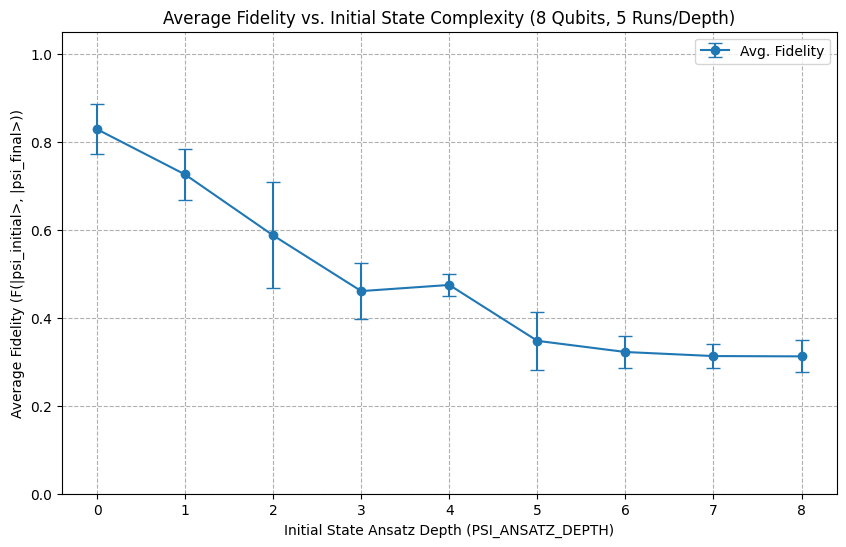

In [9]:
plt.figure(figsize=(10, 6))
plt.errorbar(depth_values, average_fidelities, yerr=std_fidelities, 
             marker='o', linestyle='-', capsize=5, label='Avg. Fidelity')
plt.xlabel("Initial State Ansatz Depth (PSI_ANSATZ_DEPTH)")
plt.ylabel("Average Fidelity (F(|psi_initial>, |psi_final>))")
plt.title(f"Average Fidelity vs. Initial State Complexity ({NUM_QUBITS_EXP} Qubits, {NUM_RUNS_PER_DEPTH} Runs/Depth)")
plt.xticks(depth_values)
plt.ylim(0, 1.05) # Fidelity is between 0 and 1
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

## 6. Execution Guidance & Expected Output

1.  **Kernel:** Ensure a Python 3 kernel with `qiskit`, `numpy`, `scipy`, and `matplotlib`.
2.  **Run All Cells:** Execute cells sequentially from top to bottom.
3.  **Configuration (Cell 2):**
    *   `NUM_QUBITS_EXP`: Set to 8 as requested.
    *   `MAX_PSI_ANSATZ_DEPTH`: Determines the range of depths (0 to 8).
    *   `NUM_RUNS_PER_DEPTH`: Number of random instances to average over for each depth. Higher means more statistically robust results but longer runtime.
    *   `SCIPY_COBYLA_MAXITER`, `SCIPY_COBYLA_TOL`: Optimizer settings. Reducing `MAXITER` (e.g., to 1000-2000) and slightly increasing `TOL` (e.g., to 1e-5 or 1e-4) will significantly speed up the experiment, especially with 8 qubits, at the cost of potentially less optimal projectors.
    *   `VISUALIZE_CIRCUITS`, `VERBOSE_OPTIMIZATION`: Keep `False` for speed during bulk runs.
4.  **Patience:** This experiment can be computationally intensive, especially for 8 qubits and higher ansatz depths, as each run involves multiple optimizations. The total time will be roughly `(MAX_PSI_ANSATZ_DEPTH + 1) * NUM_RUNS_PER_DEPTH * (NUM_QUBITS_EXP - 1) * (time_per_optimization)`.

### Expected Output
- Print statements showing the progress for each depth and run.
- The average fidelity (and standard deviation) for each depth.
- A final plot showing Average Fidelity on the Y-axis and Initial State Ansatz Depth on the X-axis.

One might hypothesize that as the initial state complexity (ansatz depth) increases, the state becomes more "globally entangled" or "robust" in a way that makes it harder to find local projectors $P_{ij}^*$ that have near-zero overlap with it. If this is true, applying $(I - P_{ij}^*)$ might change the state more significantly, potentially leading to a decrease in the final fidelity $F(|\psi_{initial}\rangle, |\psi_{final}\rangle)$ as `PSI_ANSATZ_DEPTH` increases. Alternatively, if the optimization always successfully finds projectors $P_{ij}^*$ such that $\langle\psi_{initial}|P_{ij}^*|\psi_{initial}\rangle \approx 0$, the fidelity might remain high across all depths.